# House Prices - Advanced Regression Techniques

1. [Анализ датасета и обработка данных](#1)<br>
    1.1 [Знакомство с датасетом и целевой переменной](#1.1)<br>
    1.2 [Объединение датасетов](#1.2)<br>
    1.3 [Обработка пропусков](#1.3)<br>
    1.4 [Создание новых признаков](#1.4)<br>
    1.5 [Обработка числовых и категориальных признаков](#1.5)<br>
    1.6 [Подготовка данных к моделированию](#1.6)
2. [Обучение моделей и предсказание](#2)
3. [Результаты на предсказании](#3)
4. [Анализ результатов](#4)
5. [Повторное предсказание](#5)
6. [Результаты повторного предсказания](#6)
7. [Кластеризация](#7)

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from scipy.stats import skew, norm
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from yellowbrick.cluster import silhouette_visualizer
from sklearn.cluster import KMeans
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#import h2o
#h2o.init()
#from h2o.estimators import H2OTargetEncoderEstimator

plt.style.use('ggplot')

In [3]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

<a id='1'></a>

# 1. Анализ датасета и обработка данных

<a id='1.1'></a>

## 1.1 Знакомство с датасетом и целевой переменной

In [4]:
# Загружаем данные
path_train = 'house_train.csv'
path_test = 'house_test.csv'
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

In [5]:
# Смотрим датасет
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

In [6]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [8]:
# Посмотрим, нормально ли распределена наша target variable - 'SalePrice'

In [9]:
pd.DataFrame(df_train['SalePrice'].describe())

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


E:\anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
E:\anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 1.883
Kurtosis: 6.536
Skewness after log1p: 0.121
Kurtosis after log1p: 0.81


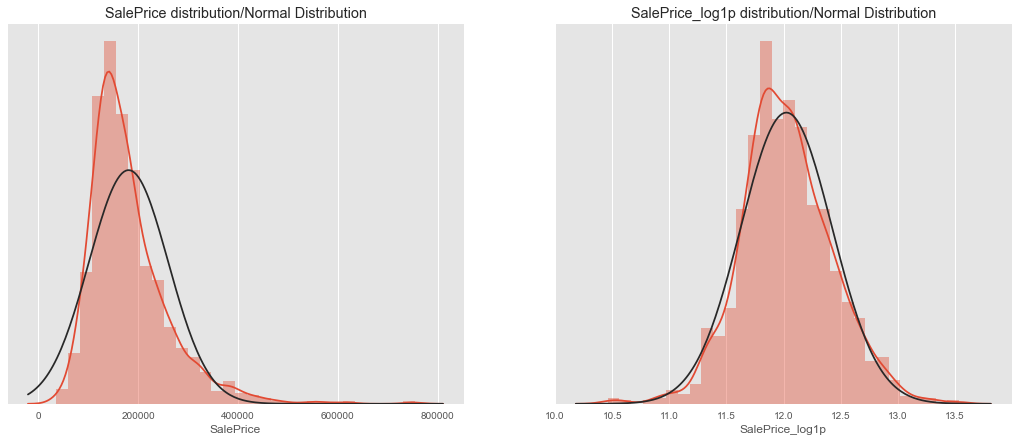

In [10]:
# Построим два графика: 
# на первом графике оригинальное распределение нашей целевой переменной
# на втором - прологарифмированное
y_log1p = np.log1p(df_train['SalePrice'])
mu, sigma = norm.fit(df_train['SalePrice'])
mu_log, sigma_log = norm.fit(y_log1p)
plt.figure(figsize = (18,7))
plt.subplot(1,2,1)
sns.distplot(df_train['SalePrice'], fit = norm, bins=30)
plt.title('SalePrice distribution/Normal Distribution')
plt.xlabel('SalePrice')
plt.ylabel('')
plt.yticks([])
plt.subplot(1,2,2)
sns.distplot(y_log1p, fit = norm, bins=30)
plt.title('SalePrice_log1p distribution/Normal Distribution')
plt.xlabel('SalePrice_log1p')
plt.ylabel('')
plt.yticks([])
print("Skewness:", df_train['SalePrice'].skew().round(3))
print("Kurtosis:", df_train['SalePrice'].kurt().round(3))
print("Skewness after log1p:", y_log1p.skew().round(3))
print("Kurtosis after log1p:", y_log1p.kurt().round(3));

In [11]:
# Видим, что после логарифмирования 'SalePrice' очень близка к нормальному распределению

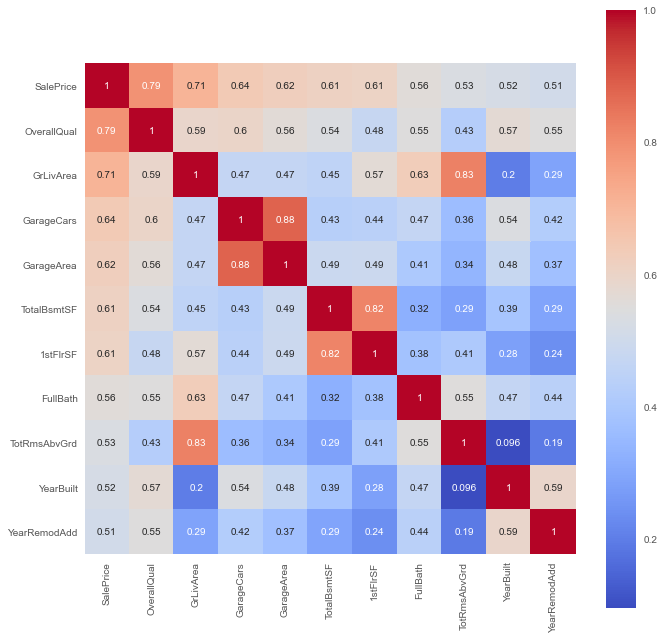

In [12]:
plt.figure(figsize=(11,11))
c = df_train.corr().nlargest(11, 'SalePrice')['SalePrice'].index
mat = np.corrcoef(df_train[c].values.T)
sns.heatmap(mat, yticklabels=c.values, xticklabels=c.values, annot=True, square=True, cmap='coolwarm');
# Топ10 числовых признаков имеют сильную корреляцию с 'SalePrice', плюс можно заметить высокую корреляцию между признаками '1stFlrSF' и 'TotalBsmntSF'(0.82),
# 'GrLivArea' и 'TotRmsAbvGrd'(0.83), 'GarageCars' и 'GarageArea'(0.88)

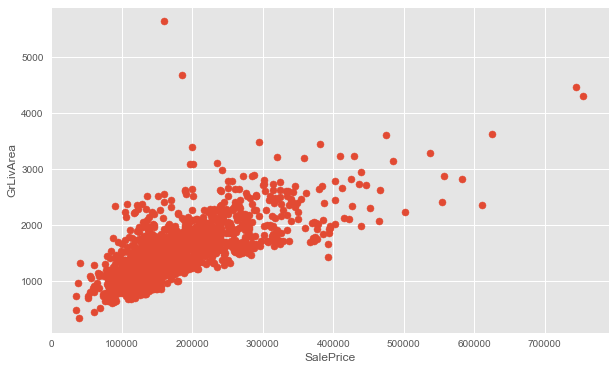

In [13]:
# Смотрим на аномалии по SalePrice/GrLivArea
plt.figure(figsize=(10,6))
plt.scatter(df_train['SalePrice'], df_train['GrLivArea'])
plt.grid(True)
plt.xlabel('SalePrice')
plt.ylabel('GrLivArea');

In [14]:
# Удаляем два объекта с низкой ценой, но очень большой жилой площадью, которые больше похожи на выбросы и выбиваются из рисунка линейной зависимости
df_train = df_train.drop(df_train[(df_train['SalePrice']<200000) & (df_train['GrLivArea']>4000)].index)
df_train = df_train.reset_index(drop=True)

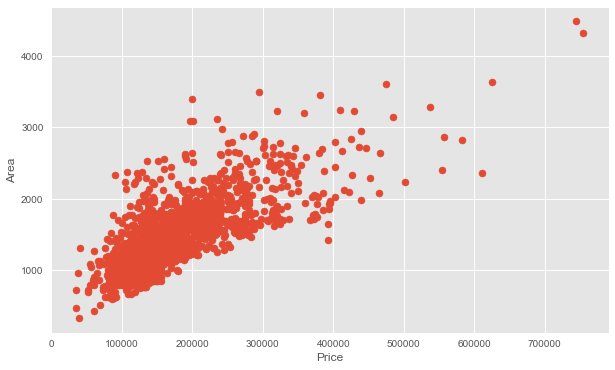

In [15]:
# Проверяем
plt.figure(figsize=(10,6))
plt.scatter(df_train['SalePrice'], df_train['GrLivArea'])
plt.grid(True)
plt.xlabel('Price')
plt.ylabel('Area');

In [16]:
# Проверяем на наличие повторных объектов в датасете
df_train[df_train.duplicated(keep=False)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


<a id='1.2'></a>

## 1.2 Объединение датасетов

In [17]:
# Запоминаем в переменные размер наших датасетов, т.к. дальше мы объединим их в 1 датафрейм для удобства обработки
train_size = len(df_train)
test_size = len(df_test)
train_size, test_size

(1458, 1459)

In [18]:
# Записываем нашу target variable в переменную 'y'. Объединяем датасеты в один и удаляем в нем колонки 'SalePrice' и 'Id'
y = df_train['SalePrice']
# не забываем прологарифмировать
y = np.log1p(y)

df = pd.concat([df_train, df_test]).reset_index(drop=True)
df.drop(['SalePrice', 'Id'], axis=1, inplace=True)
df.shape, df.index

((2917, 79), RangeIndex(start=0, stop=2917, step=1))

<a id='1.3'></a>

## 1.3 Обработка пропусков

In [19]:
# Создаем таблицу признаков, которые имеют пропущенные значения
df_nan = pd.DataFrame(df.isna().sum()[df.isna().any()].sort_values(ascending=False), columns=['NaN count'])
df_nan['NaN %'] =  df_nan.apply(lambda x: round(x * 100 / len(df), 3))
df_nan

,NaN count,NaN %
PoolQC,2908,99.691
MiscFeature,2812,96.400
Alley,2719,93.212
Fence,2346,80.425
FireplaceQu,1420,48.680
LotFrontage,486,16.661
GarageFinish,159,5.451
GarageQual,159,5.451
GarageCond,159,5.451
GarageYrBlt,159,5.451


In [20]:
# Будем идти от столбцов с наибольшим кол-вом пропусков к наименьшим.
# Если признак будет иметь подобные по природе признаки, то будем обрабатывать их вместе
# Пользуемся файлом data_description с описанием всех признаков

### PoolQC

In [21]:
# Пропущенные значения заполняем 'None', что значит отсутствие признака
df['PoolQC'] = df['PoolQC'].fillna('None')

### MiscFeature

In [22]:
# Пропущенные значения заполняем 'None', что значит отсутствие признака
df['MiscFeature'] = df['MiscFeature'].fillna('None')

### Alley

In [23]:
# Пропущенные значения заполняем 'None', что значит отсутствие признака
df['Alley'] = df['Alley'].fillna('None')

### Fence

In [24]:
# Пропущенные значения заполняем 'None', что значит отсутствие признака
df['Fence'] = df['Fence'].fillna('None')

### FireplaceQu

In [25]:
# Пропущенные значения заполняем 'None', что значит отсутствие признака
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')

### LotFrontage

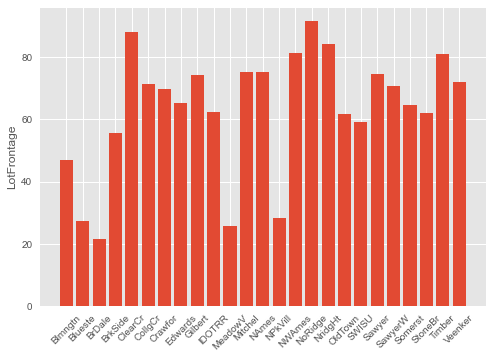

In [26]:
# Заполняем медианой по каждому району
plt.bar(df.groupby('Neighborhood')['LotFrontage'].mean().index, df.groupby('Neighborhood')['LotFrontage'].mean())
plt.xticks(rotation=45)
plt.ylabel('LotFrontage');

In [27]:
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

### GarageFinish, GarageQual, GarageCond, GarageYrBlt, GarageType, GarageArea, GarageCars

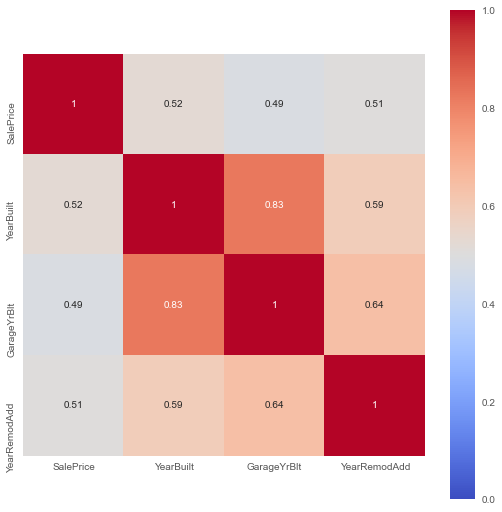

In [28]:
# В этих столбцах значение NaN = отсутствие гаража, поэтому не совсем понятно как заполнить столбец GarageYrBlt(год постройки гаража),
# если гаража на самом деле нет. Взглянем на матрицу корреляции
plt.figure(figsize=(9,9))
sns.heatmap(df_train[['SalePrice','YearBuilt', 'GarageYrBlt', 'YearRemodAdd']].corr(), annot=True, square=True, cmap='coolwarm', vmin=0);

In [29]:
# Видим, что YearBuilt(год постройки дома) и GarageYrBlt(год постройки гаража) имеют большое влияние на нашу целевую переменную Saleprice,
# но важно то, что эти два признака сильно коррелируют между собой, что и логично: в год, когда был построен дом, был построен и гараж - в большинстве случаев.
# Если заполнить пропуск в столбце GarageYrBlt у каждого дома годом его постройки YearBuilt или хотя бы просто заполнить медианой по этому столбцу,
# то получим еще более сильную корреляцию между этими двумя признаками. Поэтому принимаем решение удалить столбец GarageYrBlt
df.drop('GarageYrBlt', inplace=True, axis=1)

In [30]:
# Также ниже обнаруживаем, что все 157 объектов с пропусками в GarageType находятся и в других столбцах с пропусками,
# поэтому их мы можем сразу обработать и потом заняться оставшимися
df[(df['GarageFinish'].isna()) & (df['GarageQual'].isna()) & (df['GarageCond'].isna()) & (df['GarageType'].isna())].shape

(157, 78)

In [31]:
df.loc[df[df['GarageType'].isna()].index,'GarageFinish'] = df['GarageFinish'].fillna('None')
df.loc[df[df['GarageType'].isna()].index,'GarageQual'] = df['GarageQual'].fillna('None')
df.loc[df[df['GarageType'].isna()].index,'GarageCond'] = df['GarageCond'].fillna('None')
df['GarageType'] = df['GarageType'].fillna('None')

In [32]:
# Находим последние объекты с пропусками
df[(df['GarageFinish'].isna()) | (df['GarageQual'].isna()) | (df['GarageCond'].isna()) | (df['GarageArea'].isna()) | (df['GarageCars'].isna())]\
[['GarageFinish', 'GarageQual', 'GarageCond', 'GarageArea', 'GarageCars' ]] 

,GarageFinish,GarageQual,GarageCond,GarageArea,GarageCars
2124,NaN,NaN,NaN,360.0,1.0
2574,NaN,NaN,NaN,NaN,NaN


In [33]:
# Похоже, что у дома 2124 на самом деле есть гараж, а у 2574 - нет
# У первого заполняем пропуски mode, у второго - 'None' и нулями

In [34]:
df.loc[2124, 'GarageFinish'] = df['GarageFinish'].mode()[0]
df.loc[2124, 'GarageQual'] = df['GarageQual'].mode()[0]
df.loc[2124, 'GarageCond'] = df['GarageCond'].mode()[0]
df.loc[2574, 'GarageFinish'] = 'None'
df.loc[2574, 'GarageQual'] = 'None'
df.loc[2574, 'GarageCond'] = 'None'
df.loc[2574, 'GarageArea'] = 0
df.loc[2574, 'GarageCars'] = 0
df.loc[[2124,2574], ['GarageFinish', 'GarageQual', 'GarageCond', 'GarageArea', 'GarageCars' ]]

,GarageFinish,GarageQual,GarageCond,GarageArea,GarageCars
2124,Unf,TA,TA,360.0,1.0
2574,None,None,None,0.0,0.0


### BsmtExposure, BsmtCond, BsmtQual, BsmtFinType2, BsmtFinType1, BsmtFullBath, BsmtHalfBath,
### TotalBsmtSF, BsmtUnfSF, BsmtFinSF2, BsmtFinSF1

In [35]:
# Обнаруживаем, что все 79 объектов с пропусками в BsmtFinType1 находятся и в других столбцах с пропусками,
# поэтому их мы можем сразу обработать и потом заняться оставшимися
df[(df['BsmtExposure'].isna()) & (df['BsmtCond'].isna()) & (df['BsmtQual'].isna()) & (df['BsmtFinType2'].isna()) & (df['BsmtFinType1'].isna())].shape

(79, 78)

In [36]:
df.loc[df[df['BsmtFinType1'].isna()].index,'BsmtExposure'] = df['BsmtExposure'].fillna('None')
df.loc[df[df['BsmtFinType1'].isna()].index,'BsmtCond'] = df['BsmtCond'].fillna('None')
df.loc[df[df['BsmtFinType1'].isna()].index,'BsmtQual'] = df['BsmtQual'].fillna('None')
df.loc[df[df['BsmtFinType1'].isna()].index,'BsmtFinType2'] = df['BsmtFinType2'].fillna('None')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('None')

In [37]:
# Находим последние объекты с пропусками
df[(df['BsmtExposure'].isna()) | (df['BsmtCond'].isna()) | (df['BsmtQual'].isna()) | (df['BsmtFinType2'].isna())\
     | (df['BsmtFullBath'].isna()) | (df['BsmtHalfBath'].isna()) | (df['TotalBsmtSF'].isna()) | (df['BsmtUnfSF'].isna())\
    | (df['BsmtFinSF2'].isna()) | (df['BsmtFinSF1'].isna())]\
[['BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1']] 

,BsmtExposure,BsmtCond,BsmtQual,BsmtFinType2,BsmtFullBath,BsmtHalfBath,TotalBsmtSF,BsmtUnfSF,BsmtFinSF2,BsmtFinSF1
332,No,TA,Gd,NaN,1.0,0.0,3206.0,1603.0,479.0,1124.0
947,NaN,TA,Gd,Unf,0.0,0.0,936.0,936.0,0.0,0.0
1485,NaN,TA,Gd,Unf,0.0,0.0,1595.0,1595.0,0.0,0.0
2038,Mn,NaN,Gd,Rec,1.0,0.0,1426.0,0.0,382.0,1044.0
2118,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN
2183,No,NaN,TA,Unf,0.0,1.0,1127.0,94.0,0.0,1033.0
2186,None,None,None,None,NaN,NaN,0.0,0.0,0.0,0.0
2215,No,Fa,NaN,Unf,0.0,0.0,173.0,173.0,0.0,0.0
2216,No,TA,NaN,Unf,0.0,0.0,356.0,356.0,0.0,0.0
2346,NaN,TA,Gd,Unf,0.0,0.0,725.0,725.0,0.0,0.0


In [38]:
# Видим, что у 2118 и 2186 - нет подвала, их нужно дозаполнить нулями, остальные объекты дозаполним mode
df['BsmtFullBath'] = df['BsmtFullBath'].fillna(0)
df['BsmtHalfBath'] = df['BsmtHalfBath'].fillna(0)
df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(0)
df['BsmtUnfSF'] = df['BsmtUnfSF'].fillna(0)
df['BsmtFinSF2'] = df['BsmtFinSF2'].fillna(0)
df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(0)

df['BsmtExposure'] = df['BsmtExposure'].fillna(df['BsmtExposure'].mode()[0])
df['BsmtCond'] = df['BsmtCond'].fillna(df['BsmtCond'].mode()[0])
df['BsmtQual'] = df['BsmtQual'].fillna(df['BsmtQual'].mode()[0])
df['BsmtFinType2'] = df['BsmtFinType2'].fillna(df['BsmtFinType2'].mode()[0])

### MasVnrType, MasVnrArea

In [39]:
# Видим, что у 2608 значение в столбце MasVnrArea есть, поэтому в другом столбце пропуск заполним с помощью второго самого популярного значения(т.к. первое 'None' - оно нам не подходит).
df[(df['MasVnrArea'].isna()) | (df['MasVnrType'].isna())][['MasVnrArea', 'MasVnrType']]

,MasVnrArea,MasVnrType
234,NaN,NaN
528,NaN,NaN
649,NaN,NaN
935,NaN,NaN
972,NaN,NaN
976,NaN,NaN
1242,NaN,NaN
1277,NaN,NaN
1689,NaN,NaN
1704,NaN,NaN


In [40]:
df['MasVnrType'].value_counts()

None       1742
BrkFace     879
Stone       247
BrkCmn       25
Name: MasVnrType, dtype: int64

In [41]:
df['MasVnrType'].value_counts().index[1]

'BrkFace'

In [42]:
df.loc[2608, 'MasVnrType'] = df['MasVnrType'].value_counts().index[1]
df.loc[2608, 'MasVnrType']

'BrkFace'

In [43]:
# Теперь оставшиеся пропуски в MasVnrArea можно заменить на 0, а в MasVnrType на 'None'
df['MasVnrType'] = df['MasVnrType'].fillna('None')
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

### MSZoning

In [44]:
# Определение Nan в файле не дано. Заполняем с помощью mode
df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])

### Functional

In [45]:
# Определение Nan в файле не дано. Заполняем с помощью mode
df['Functional'] = df['Functional'].fillna(df['Functional'].mode()[0])

### Utilities

In [46]:
# Определение Nan в файле не дано, однако можно заметить, что в столбце есть только 1 объект со значением 'NoSeWa',
# 2 значения с NaN и все остальные 'AllPub'. Посмотрим, в каких датасетах они находятся
df['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [47]:
df[(df['Utilities'] == 'NoSeWa') | (df['Utilities'].isna())]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
943,20,RL,82.0,14375,Pave,None,IR1,Lvl,NoSeWa,CulDSac,...,233,0,None,None,None,0,1,2009,COD,Abnorml
1913,30,RL,109.0,21780,Grvl,None,Reg,Lvl,NaN,Inside,...,0,0,None,None,None,0,3,2009,ConLD,Normal
1943,20,RL,64.0,31220,Pave,None,IR1,Bnk,NaN,FR2,...,0,0,None,None,Shed,750,5,2008,WD,Normal


In [48]:
# Оба объекта с NaN находятся в test, а NoSewa - в train. Очевидно, что для предсказания модели этот признак бесполезен. Удаляем его
df.drop('Utilities', inplace=True, axis=1)

### Electrical

In [49]:
# Определение Nan в файле не дано. Заполняем с помощью mode
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

### KitchenQual

In [50]:
# Определение Nan в файле не дано. Заполняем с помощью mode
df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])

### Exterior1st, Exterior2nd

In [51]:
# Определение Nan в файле не дано. Заполняем с помощью mode
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])

### SaleType

In [52]:
# Определение Nan в файле не дано. Заполняем с помощью mode
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])

In [53]:
# Проверяем, что пропущенных значений не осталось
df.isna().sum().unique(), df.shape

(array([0], dtype=int64), (2917, 77))

<a id='1.4'></a>

## 1.4 Создание новых признаков

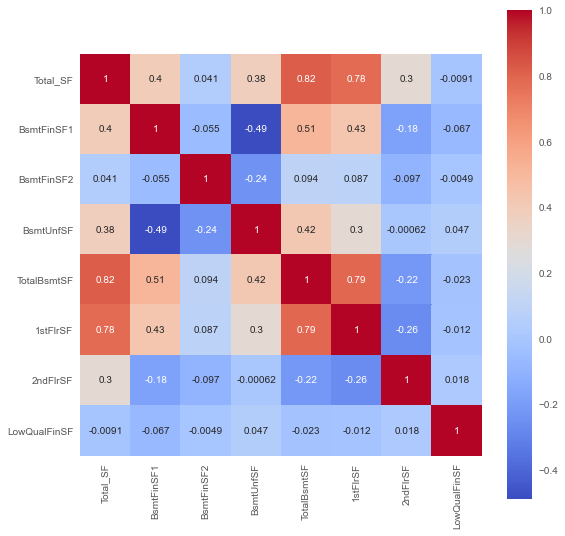

In [56]:
# Общая площадь
df['Total_SF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
plt.figure(figsize=(9,9))
sns.heatmap(df[['Total_SF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF']].corr(), annot=True, square=True, cmap='coolwarm');

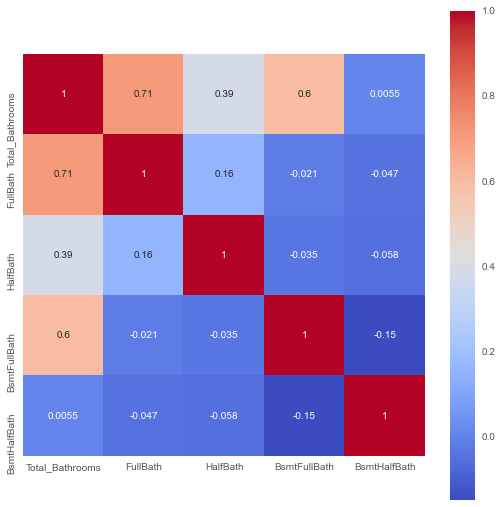

In [57]:
# Все ванные комнаты
df['Total_Bathrooms'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
plt.figure(figsize=(9,9))
sns.heatmap(df[['Total_Bathrooms', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']].corr(), annot=True, square=True, cmap='coolwarm');

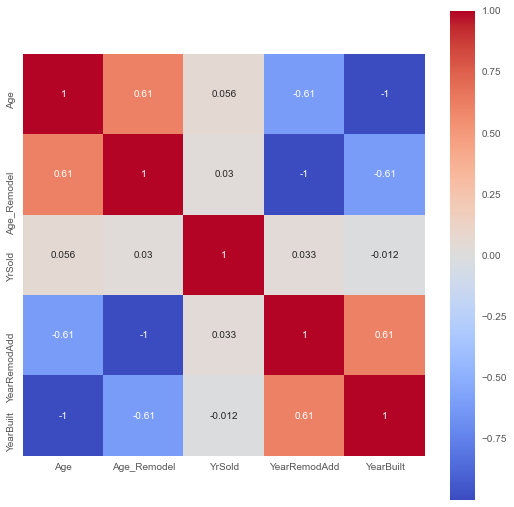

In [58]:
# Год постройки(YearBuilt) заменим на возраст дома(Age)
# Год реконструкции дома(YearRemodAdd) заменим на кол-во лет без реконструкции(Age_Remodel)
df['Age'] = df['YrSold'] - df['YearBuilt']
df['Age_Remodel'] = df['YrSold'] - df['YearRemodAdd']
plt.figure(figsize=(9,9))
sns.heatmap(df[['Age', 'Age_Remodel', 'YrSold', 'YearRemodAdd', 'YearBuilt']].corr(), annot=True, square=True, cmap='coolwarm')
df.drop(['YearBuilt', 'YearRemodAdd'], axis=1, inplace=True);

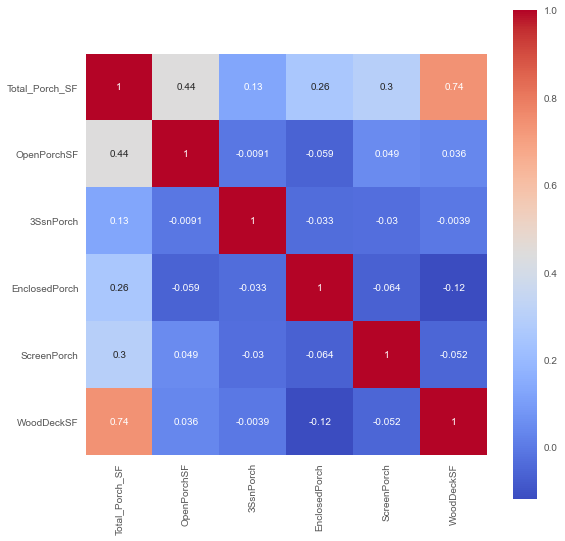

In [59]:
# Общая площадь веранды
df['Total_Porch_SF'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']
plt.figure(figsize=(9,9))
sns.heatmap(df[['Total_Porch_SF', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF']].corr(), annot=True, square=True, cmap='coolwarm');

<a id='1.5'></a>

## 1.5 Обработка числовых и категориальных признаков

In [60]:
# Определим числовые признаки, которые на самом деле являются категориальными.
for i in [
    'MSSubClass',
    'MoSold',
    'YrSold',
#     'OverallQual',
#     'OverallCond'
         ]:
    df[i] = df[i].astype('str')

In [61]:
# # Преобразуем categorical ordinal признаки (имеющие порядок/степень сравнения)
# all_map  = {
#             'Pave': 1, 'Grvl': 2,
#             'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3,
#             'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5,
#             'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4,
#             'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6,      
#             'Y': 1, 'N': 0,
#             'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4,
#             'Unf': 1, 'RFn': 2, 'Fin': 3,
#             'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2': 5, 'Min1': 6, 'Typ': 7
#             }
# #
# land_slope_map = {'Sev': 0, 'Mod': 1, 'Gtl': 2}
# #
# paved_drive_map = {'N': 0, 'P': 1, 'Y': 2}
# #
# df['Street'] = df['Street'].map(all_map)
# df['Alley'] = df['Alley'].map(all_map)
# df['LotShape'] = df['LotShape'].map(all_map)
# df['ExterQual'] = df['ExterQual'].map(all_map)
# df['ExterCond'] = df['ExterCond'].map(all_map)
# df['BsmtQual'] = df['BsmtQual'].map(all_map)
# df['BsmtCond'] = df['BsmtCond'].map(all_map)
# df['BsmtExposure'] = df['BsmtExposure'].map(all_map)
# df['BsmtFinType1'] = df['BsmtFinType1'].map(all_map)
# df['BsmtFinType2'] = df['BsmtFinType2'].map(all_map)
# df['HeatingQC'] = df['HeatingQC'].map(all_map)
# df['CentralAir'] = df['CentralAir'].map(all_map)
# df['KitchenQual'] = df['KitchenQual'].map(all_map)
# df['FireplaceQu'] = df['FireplaceQu'].map(all_map)
# df['GarageFinish'] = df['GarageFinish'].map(all_map)
# df['GarageQual'] = df['GarageQual'].map(all_map)
# df['GarageCond'] = df['GarageCond'].map(all_map)
# df['PoolQC'] = df['PoolQC'].map(all_map)
# df['Fence'] = df['Fence'].map(all_map)
# df['Functional'] = df['Functional'].map(all_map)
# #
# df['PavedDrive'] = df['PavedDrive'].map(paved_drive_map)
# #
# df['LandSlope'] = df['LandSlope'].map(land_slope_map)

In [62]:
# В самом начале анализа мы уже видели positive skew нашей целевой переменной, теперь взглянем на числовые признаки
skewed_features = df[df.select_dtypes(include=['float64', 'int64']).columns].skew().sort_values(ascending=False)
pd.DataFrame({'Skew' :skewed_features})

,Skew
MiscVal,21.950962
PoolArea,17.697766
LotArea,13.116240
LowQualFinSF,12.090757
3SsnPorch,11.377932
KitchenAbvGr,4.302763
BsmtFinSF2,4.146636
EnclosedPorch,4.004404
ScreenPorch,3.947131
BsmtHalfBath,3.932018


In [63]:
# Посмотрим, как изменится коэффициент асимметрии, если прологарифмировать
pd.DataFrame(np.log1p(df[skewed_features[skewed_features > 1].index]).skew().sort_values(ascending=False), columns=['Skew'])

,Skew
PoolArea,15.631314
3SsnPorch,8.826656
LowQualFinSF,8.559041
MiscVal,5.214687
BsmtHalfBath,3.775149
KitchenAbvGr,3.520694
ScreenPorch,2.946085
BsmtFinSF2,2.462526
EnclosedPorch,1.960960
MasVnrArea,0.538731


In [64]:
# Применим логарифмирование
for column in skewed_features[skewed_features > 1].index:
    df[column] = np.log1p(df[column])

In [65]:
# Проверяем, что пропущенных значений нет и все преобразования прошли без ошибок
df.isna().sum().unique()

array([0], dtype=int64)

In [66]:
# Итоговое количество числовых признаков
len(df.select_dtypes(include=['float64', 'int64']).columns), df.select_dtypes(include=['float64', 'int64']).columns

(35,
 Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
        'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
        '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
        'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
        'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
        'Total_SF', 'Total_Bathrooms', 'Age', 'Age_Remodel', 'Total_Porch_SF'],
       dtype='object'))

In [67]:
# Итоговое количество категориальныых признаков
len(df.select_dtypes(include='O').columns), df.select_dtypes(include='O').columns

(45,
 Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
        'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
        'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold',
        'YrSold', 'SaleType', 'SaleCondition'],
       dtype='object'))

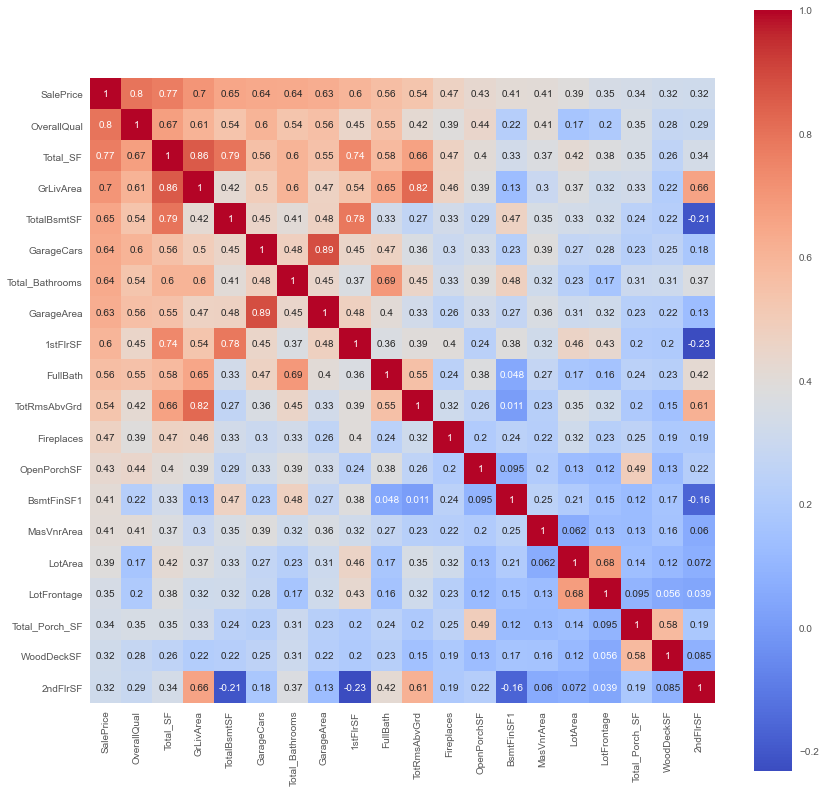

In [237]:
# Итоговая матрица корреляции
plt.figure(figsize=(14,14))
c = df[:train_size].join(df_train['SalePrice']).corr().nlargest(20, 'SalePrice')['SalePrice'].index
mat = np.corrcoef(df[:train_size].join(df_train['SalePrice'])[c].values.T)
sns.heatmap(mat, yticklabels=c.values, xticklabels=c.values, annot=True, square=True, cmap='coolwarm');

## H2O Target Encoder Estimator

In [69]:
# numerical = df.select_dtypes(include=['float64', 'int64'])
# categorical = df.select_dtypes(include=['O'])

In [70]:
# part_train, part_test = df[:train_size], df[train_size:]
# part_test = part_test.reset_index(drop=True)
# part_train.shape, part_test.shape

In [71]:
# joined = part_train.join(df_train['SalePrice'])
# joined

In [72]:
# fold_column = 'kfold_column'
# h2o_joined = h2o.H2OFrame(joined)
# h2o_part_test = h2o.H2OFrame(part_test)
# h2o_joined[fold_column] = h2o_joined.kfold_column(n_folds=5, seed=7)

In [73]:
# h2o_te = H2OTargetEncoderEstimator(fold_column=fold_column,
#                                       data_leakage_handling='k_fold',
#                                       blending=True,                                   
#                                       inflection_point=3,
#                                       smoothing=10,
#                                       noise=0.15,
#                                       keep_original_categorical_columns=False,
#                                       seed=7)

In [74]:
# # Возьмем наиболее вариативные признаки
# df.select_dtypes(["object"]).nunique()

In [75]:
# h2o_te.train(x=['Neighborhood', 'MSSubClass'],
#             y='SalePrice',
#             training_frame=h2o_joined)

In [76]:
# train_te = h2o_te.transform(frame=h2o_joined, as_training=True)
# test_te = h2o_te.transform(frame=h2o_part_test, noise=0)

In [77]:
# part_train = train_te.as_data_frame()
# part_train.drop(['kfold_column', 'SalePrice'], inplace=True, axis=1)
# part_train.head()

In [78]:
# part_test = test_te.as_data_frame()
# part_test.head()

In [79]:
# plt.figure(figsize=(18,18))
# c = part_train.join(df_train['SalePrice']).corr().nlargest(40, 'SalePrice')['SalePrice'].index
# mat = np.corrcoef(part_train.join(df_train['SalePrice'])[c].values.T)
# sns.heatmap(mat, yticklabels=c.values, xticklabels=c.values, annot=True, square=True, cmap='coolwarm');

In [80]:
# # Объединяем обратно 
# df = pd.concat([part_train, part_test]).reset_index(drop=True)

<a id='1.6'></a>

## 1.6 Подготовка данных к моделированию

In [81]:
# Преобразуем все оставшиеся категориальные признаки в числовые
df_final = pd.get_dummies(df)
df_final.shape, df_final.dtypes.unique()

((2917, 331),
 array([dtype('float64'), dtype('int64'), dtype('uint8')], dtype=object))

In [82]:
# Разбиваем общий обработанный датасет обратно на обучающую и тестовую выборки
x_train, x_test = df_final[:train_size].to_numpy(), df_final[train_size:].to_numpy()

In [83]:
# Проверяем размерности наших выборок
x_train.shape, y.shape, x_test.shape

((1458, 331), (1458,), (1459, 331))

<a id='2'></a>

# 2. Обучение моделей и предсказание

In [84]:
# По поводу метрики: на Kaggle для оценки используется метрика RMSLE(root mean squared logarithmic error), но так как мы нашу целевую переменную уже прологарифмировали, то
# будем использовать метрику RMSE(root mean squared error), чтобы в итоге получать оценку по метрике RMSLE

In [118]:
# Попробуем несколько моделей и разные методы нормализации данных
# Также сразу используем gridsearch для подбора оптимальных гиперпараметров
def training(x_tr, y_tr, x_te, models, params, scalers):
    number = 1 # для нумерования используемых моделей
    for scaler in scalers:
        
        # нормируем
        x_tr_norm = scaler.fit_transform(x_tr)
        x_te_norm = scaler.transform(x_te)
        
        for model, param in zip(models, params):
            
            # создаем модель
            cv = GridSearchCV(model, param_grid=param, scoring='neg_root_mean_squared_error',
                        cv=5, refit=True, n_jobs=-1, verbose=10)
            
            # обучаем
            cv.fit(x_tr_norm, y_tr)
            
            # выводим результаты
            print(f'model number {number}:', cv.best_estimator_)
            print('scaler:', scaler)
            print('parameters:', cv.best_params_)
            print('RMSLE:', -cv.best_score_)
            print('_'*100)
            print('_'*100)
            
            # делаем предсказание и записываем результат в файл
            result = np.expm1(cv.best_estimator_.predict(x_te_norm))
            df_test['SalePrice'] = result
            df_test[['Id', 'SalePrice']].to_csv(f'model_number_{number}.csv', index=False)
            number +=1

In [119]:
# модели
m = [
    Lasso(),
    
    Ridge(),
    
    XGBRegressor(objective='reg:squarederror'),
    
    LGBMRegressor(objective='regression')
    ]
# параметры для подбора
p = [    
    {'alpha' : [1e-15, 1e-10, 1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10]},
    
    {'alpha' : [1e-15, 1e-10, 1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 100, 500, 1000]},
    
    {'n_estimators': [1000],
    'learning_rate': [0.01, 0.1],
    'max_depth': [2, 3, 4, 5, 6],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.2, 0.3, 0.5, 0.75, 1]},
    
    {'n_estimators': [1000],
    'learning_rate': [0.01, 0.1],
    'max_bin' : [200, 255],
    'max_depth': [-1, 2, 3, 4, 5, 6],
    'num_leaves': [2, 5, 10, 20, 30, 40],
    'feature_fraction': [0.2, 0.3, 0.5, 0.75, 1]},
    ]
# методы нормализации
s = [
    StandardScaler(),
    
    RobustScaler()
    ]

In [120]:
training(x_tr=x_train, y_tr=y, x_te=x_test, models=m, params=p, scalers=s)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  46 out of  55 | elapsed:    4.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  52 out of  55 | elapsed:    4.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0409s.) Setting batch_size=2.


model number 1: Lasso(alpha=0.001)
scaler: StandardScaler()
parameters: {'alpha': 0.001}
RMSLE: 0.11449520865048254
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1217s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.3s finished


model number 2: Ridge(alpha=500)
scaler: StandardScaler()
parameters: {'alpha': 500}
RMSLE: 0.11737162006226645
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2

model number 3: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
scaler: StandardScaler()
parameters: {'colsample_bytree': 0.2, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1000}
RMSLE: 0.11316140469427698
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Fitting 5 folds for each of 720 candidates, totalli

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

model number 4: LGBMRegressor(feature_fraction=0.2, learning_rate=0.01, max_bin=200,
              max_depth=5, n_estimators=1000, num_leaves=30,
              objective='regression')
scaler: StandardScaler()
parameters: {'feature_fraction': 0.2, 'learning_rate': 0.01, 'max_bin': 200, 'max_depth': 5, 'n_estimators': 1000, 'num_leaves': 30}
RMSLE: 0.1149037342877155
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  46 out of  55 | elapsed:    2.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  52 out of  55 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    2.3s finished


model number 5: Lasso(alpha=0.001)
scaler: RobustScaler()
parameters: {'alpha': 0.001}
RMSLE: 0.10995967542121594
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0449s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1506s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


model number 6: Ridge(alpha=10)
scaler: RobustScaler()
parameters: {'alpha': 10}
RMSLE: 0.11230078397639362
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  2.9min
[Paralle

model number 7: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
scaler: RobustScaler()
parameters: {'colsample_bytree': 0.2, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1000}
RMSLE: 0.11315417858993435
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Fitting 5 folds for each of 720 candidates, totalling

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
model number 8: LGBMRegressor(feature_fraction=0.2, learning_rate=0.01, max_bin=200,
              max_depth=5, n_estimators=1000, num_leaves=20,
              objective='regression')
scaler: RobustScaler()
parameters: {'feature_fraction': 0.2, 'learning_rate': 0.01, 'max_bin': 200, 'max_depth': 5, 'n_estimators': 1000, 'num_leaves': 20}
RMSLE: 0.11510480808996507
____________________________________________________________________________________________________
____________________________________________________________________________________________________


<a id='3'></a>

# 3. Результаты на предсказании

In [ ]:
# На тесте модели показали следующие результаты:
# 1. Ridge - RobustScaler - 0.12478
# 2. LGMB - StandardScaler - 0.12520
# 3. LGBM - RobustScaler - 0.12534
# 4. Lasso - RobustScaler - 0.12606
# 5. Lasso - StandardScaler - 0.13043
# 6. Ridge - StandardScaler - 0.13200
# 7. XGBoost - RobustScaler - 0.13524
# 8. XGBoost - StandardScaler - 0.13526

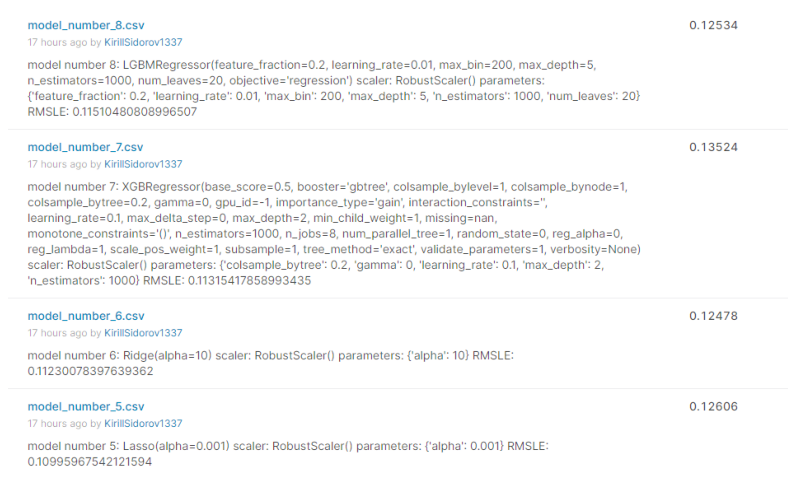

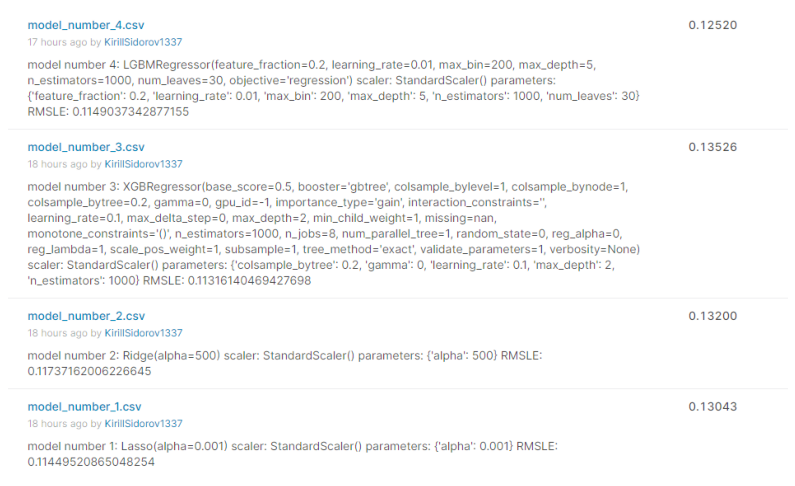

In [211]:
img1 = mpimg.imread('defolt2.png')
img2 = mpimg.imread('defolt1.png')
fig = plt.figure(figsize=(14,14))
imgplot = plt.imshow(img1)
plt.xticks([])
plt.yticks([])
fig = plt.figure(figsize=(14,14))
imgplot = plt.imshow(img2)
plt.xticks([])
plt.yticks([]);

<a id='4'></a>

# 4. Анализ результатов

In [153]:
# Попробуем улучшить модели и наш результат.
# Для этого возьмем модель LGBM и посмотрим на 'Permutation importance' признаков.
# Так мы увидим при перемешивании значений каких признаков результат модели будет сильнее всего ухудшаться.
# И посмотрим на 'Feature importance' - какие признаки и как часто их использовала модель для построения деревьев.
x_train_norm = StandardScaler().fit_transform(x_train)
train_X, val_X, train_y, val_y = train_test_split(x_train_norm, y, random_state=42, test_size=0.2)
lgbm_permutation = LGBMRegressor(feature_fraction=0.2, learning_rate=0.01, max_bin=200,
              max_depth=5, n_estimators=1000, num_leaves=30,
              objective='regression')
lgbm_permutation.fit(train_X, train_y)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


LGBMRegressor(feature_fraction=0.2, learning_rate=0.01, max_bin=200,
              max_depth=5, n_estimators=1000, num_leaves=30,
              objective='regression')

In [155]:
perm = permutation_importance(lgbm_permutation, val_X, val_y,
                              n_repeats=100,
                              random_state=42,
                              scoring='neg_root_mean_squared_error', n_jobs=-1)

In [160]:
# Создаем таблицы с результатами: 'feature importance' и 'permutation importance'
df_perm_imp = pd.concat([pd.DataFrame(perm.importances_mean, columns=['Permutation Importance, RMSLE'], index=df_final.columns),
           pd.DataFrame(perm.importances_std, columns=['std, +/-'], index=df_final.columns)], axis=1).sort_values('Permutation Importance, RMSLE', ascending=False)

df_feat_imp = pd.DataFrame(lgbm_permutation.feature_importances_, columns=['Feature importance'], index=df_final.columns).sort_values('Feature importance', ascending=False)

In [168]:
# Посмотрим на кол-во признаков, которые ни разу не были использованы моделью при построении деревьев
df_feat_imp.loc[df_feat_imp['Feature importance'] == 0, 'Feature importance'].value_counts()

0    144
Name: Feature importance, dtype: int64

In [169]:
# Посмотрим на кол-во признаков, которые на оценку модели не влияют при перемешивании их значений
df_perm_imp.loc[df_perm_imp['Permutation Importance, RMSLE'] == 0, 'Permutation Importance, RMSLE'].value_counts()

0.0    144
Name: Permutation Importance, RMSLE, dtype: int64

In [170]:
# Посмотрим на пересечение множеств этих признаков
len(set(df_feat_imp[df_feat_imp['Feature importance'] == 0].index) & set(df_perm_imp[df_perm_imp['Permutation Importance, RMSLE'] == 0].index))

144

In [ ]:
# Видим, что все нулевые признаки совпадают - даже при случайном перемешивании значений эти признаки имеют нулевой вес

In [171]:
# Посмотрев на таблицы, увидим что в топе важности находятся в целом одни и те же признаки
display_side_by_side([df_perm_imp.head(40), df_feat_imp.head(40)], ['First 40 features_perm', 'First 40 Coefficients'])

,"Permutation Importance, RMSLE","std, +/-"
Total_SF,0.036171,0.003738
OverallQual,0.032616,0.003247
OverallCond,0.013241,0.001725
GrLivArea,0.010850,0.001914
Age,0.009444,0.001672
Age_Remodel,0.007653,0.001386
Total_Bathrooms,0.006140,0.001334
GarageCars,0.005552,0.001280
LotArea,0.004725,0.000939
1stFlrSF,0.004150,0.000925


In [ ]:
# Попробуем избавиться от нулевых признаков, являющихся пересечением этих двух таблиц
df_final.drop(list(set(df_feat_imp[df_feat_imp['Feature importance'] == 0].index) & set(df_perm_imp[df_perm_imp['Permutation Importance, RMSLE'] == 0].index)), inplace=True, axis=1)

<a id='5'></a>

# 5. Повторное предсказание

In [ ]:
# Обучим модели снова, но уже без этих признаков

In [178]:
x_train, x_test = df_final[:train_size].to_numpy(), df_final[train_size:].to_numpy()
x_train.shape, y.shape, x_test.shape

((1458, 187), (1458,), (1459, 187))

In [181]:
# Не будем брать XGBoost, который показал худший результат на тесте
m_new = [
    Lasso(),
    
    Ridge(),
        
    LGBMRegressor(objective='regression')
    ]
# Попробуем еще лучше оптимизировать гиперпараметры
p_new = [    
    {'alpha' : [1e-5,
                1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4,
                1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 9e-3,
                1e-2,
                1e-1,
                1]},
    
    {'alpha' : [1e-5,
                1e-4,
                1e-3,
                1e-2,
                1e-1,
                1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
               100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]},
        
    {'n_estimators': [1000, 2000, 5000],
    'learning_rate': [0.005, 0.01],
    'max_bin' : [200, 255],
    'max_depth': [3, 4, 5, 6, 7],
    'num_leaves': [10, 20, 25, 30, 35, 40],
    'feature_fraction': [0.1, 0.15, 0.2, 0.25, 0.3, 0.5]},
    ]

s_new = [
    StandardScaler(),
    
    RobustScaler()
    ]

In [182]:
training(x_tr=x_train, y_tr=y, x_te=x_test, models=m_new, params=p_new, scalers=s_new)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1966s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1930s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  95 out of 110 | elapsed:    3.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 107 out of 110 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using 

model number 1: Lasso(alpha=0.002)
scaler: StandardScaler()
parameters: {'alpha': 0.002}
RMSLE: 0.11061752636820503
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0369s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0748s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    0.3s finished


model number 2: Ridge(alpha=100)
scaler: StandardScaler()
parameters: {'alpha': 100}
RMSLE: 0.11302685029537267
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
model number 3: LGBMRegressor(feature_fraction=0.25, learning_rate=0.005, max_bin=200,
              max_depth=3, n_estimators=5000, num_leaves=10,
              objective='regression')
scaler: StandardScaler()
parameters: {'feature_fraction': 0.25, 'learning_rate': 0.005, 'max_bin': 200, 'max_depth': 3, 'n_estimators': 5000, 'num_leaves': 10}
RMSLE: 0.11345982933628869
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1182s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1964s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  95 out of 110 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 107 out of 110 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    0.9s finished


model number 4: Lasso(alpha=0.0006)
scaler: RobustScaler()
parameters: {'alpha': 0.0006}
RMSLE: 0.11098074257065516
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0229s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0359s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0773s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    0.3s finished


model number 5: Ridge(alpha=20)
scaler: RobustScaler()
parameters: {'alpha': 20}
RMSLE: 0.11213920434504718
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
model number 6: LGBMRegressor(feature_fraction=0.2, learning_rate=0.01, max_bin=255,
              max_depth=4, n_estimators=2000, num_leaves=10,
              objective='regression')
scaler: RobustScaler()
parameters: {'feature_fraction': 0.2, 'learning_rate': 0.01, 'max_bin': 255, 'max_depth': 4, 'n_estimators': 2000, 'num_leaves': 10}
RMSLE: 0.11358810013330027
____________________________________________________________________________________________________
____________________________________________________________________________________________________


<a id='6'></a>

# 6. Результаты повторного предсказания

In [ ]:
# Результат как на обучении так и на тесте удалось улучшить.
# Лучшая модель: Lasso - StandardScaler - 0.12316

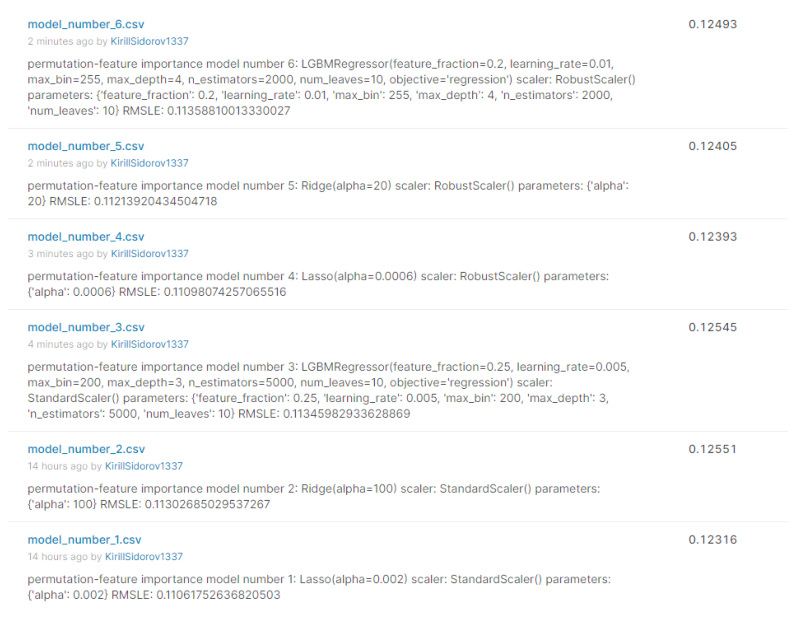

In [213]:
img3 = mpimg.imread('after-permutation-feature-importance.png')
fig = plt.figure(figsize=(14,14))
imgplot = plt.imshow(img3)
plt.xticks([])
plt.yticks([]);

In [ ]:
# Итоговый результат: 543 из 4416

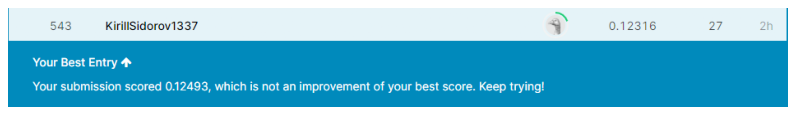

In [214]:
img4 = mpimg.imread('result.png')
fig = plt.figure(figsize=(14,14))
imgplot = plt.imshow(img4)
plt.xticks([])
plt.yticks([]);

<a id='7'></a>

# 7. Кластеризация

In [218]:
# Интереса ради попробуем провести кластеризацию и посмотреть, можно ли наши дома разделить на кластеры

In [287]:
df.dtypes.unique()

array([dtype('O'), dtype('float64'), dtype('int64')], dtype=object)

In [288]:
df_clust = df.select_dtypes(include=['float64', 'int64'])
df_clust.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Total_SF,Total_Bathrooms,Age,Age_Remodel,Total_Porch_SF
0,4.189655,9.042040,7,5,5.283204,706.0,0.0,150.0,856.0,6.753438,...,0.000000,0.0,0.0,0.0,0.0,7.850493,3.5,5,5,4.127134
1,4.394449,9.169623,6,8,0.000000,978.0,0.0,284.0,1262.0,7.141245,...,0.000000,0.0,0.0,0.0,0.0,7.833996,2.5,31,31,5.700444
2,4.234107,9.328212,7,5,5.093750,486.0,0.0,434.0,920.0,6.825460,...,0.000000,0.0,0.0,0.0,0.0,7.903596,3.5,7,6,3.761200
3,4.110874,9.164401,7,5,0.000000,216.0,0.0,540.0,756.0,6.869014,...,5.609472,0.0,0.0,0.0,0.0,7.813592,2.0,91,36,5.730100
4,4.442651,9.565284,8,5,5.860786,655.0,0.0,490.0,1145.0,7.044033,...,0.000000,0.0,0.0,0.0,0.0,8.114923,3.5,8,8,5.624018


In [289]:
X = StandardScaler().fit_transform(df_clust)

In [290]:
# До преобразования пространства попробуем оценить silhouette_score 
# Видим, что никакой структуры особо не наблюдается
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans_y = kmeans.fit_predict(X)
    print(f'количество кластеров {i},', 'silhouette_score =', silhouette_score(X, kmeans_y))

количество кластеров 2, silhouette_score = 0.16295127012788357
количество кластеров 3, silhouette_score = 0.13598503615216995
количество кластеров 4, silhouette_score = 0.11635944012137311
количество кластеров 5, silhouette_score = 0.10280880348968591
количество кластеров 6, silhouette_score = 0.10559906250993133
количество кластеров 7, silhouette_score = 0.09298190637433748
количество кластеров 8, silhouette_score = 0.11147585558141336
количество кластеров 9, silhouette_score = 0.10385395764327009
количество кластеров 10, silhouette_score = 0.10587132923691717


In [291]:
# Преобразуем пространство разными методами
pca = PCA(n_components=2)
x_pca = pca.fit_transform(X)

In [292]:
tsne = TSNE(n_components=2, perplexity=10)
x_tsne = tsne.fit_transform(X)

In [293]:
umap = UMAP(n_components=2, n_neighbors=10)
x_umap = umap.fit_transform(X)

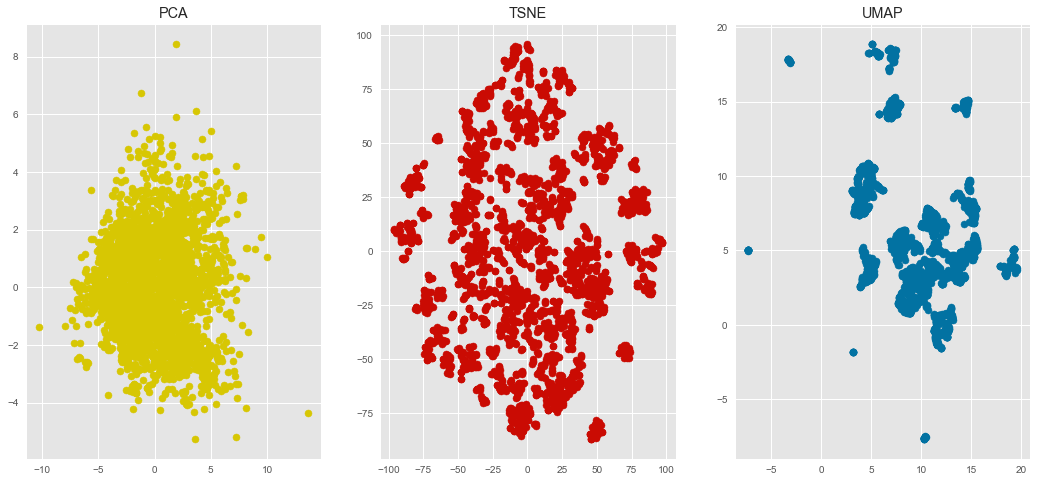

In [294]:
# Визуализируем результаты на плоскости
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))
ax1.scatter(x_pca[:, 0], x_pca[:, 1], c='y')
ax2.scatter(x_tsne[:, 0], x_tsne[:, 1], c='r')
ax3.scatter(x_umap[:, 0], x_umap[:, 1], c='b')
ax1.set_title('PCA')
ax2.set_title('TSNE')
ax3.set_title('UMAP');

In [316]:
# Посмотрим на метод UMAP в зависимости от кол-ва соседей

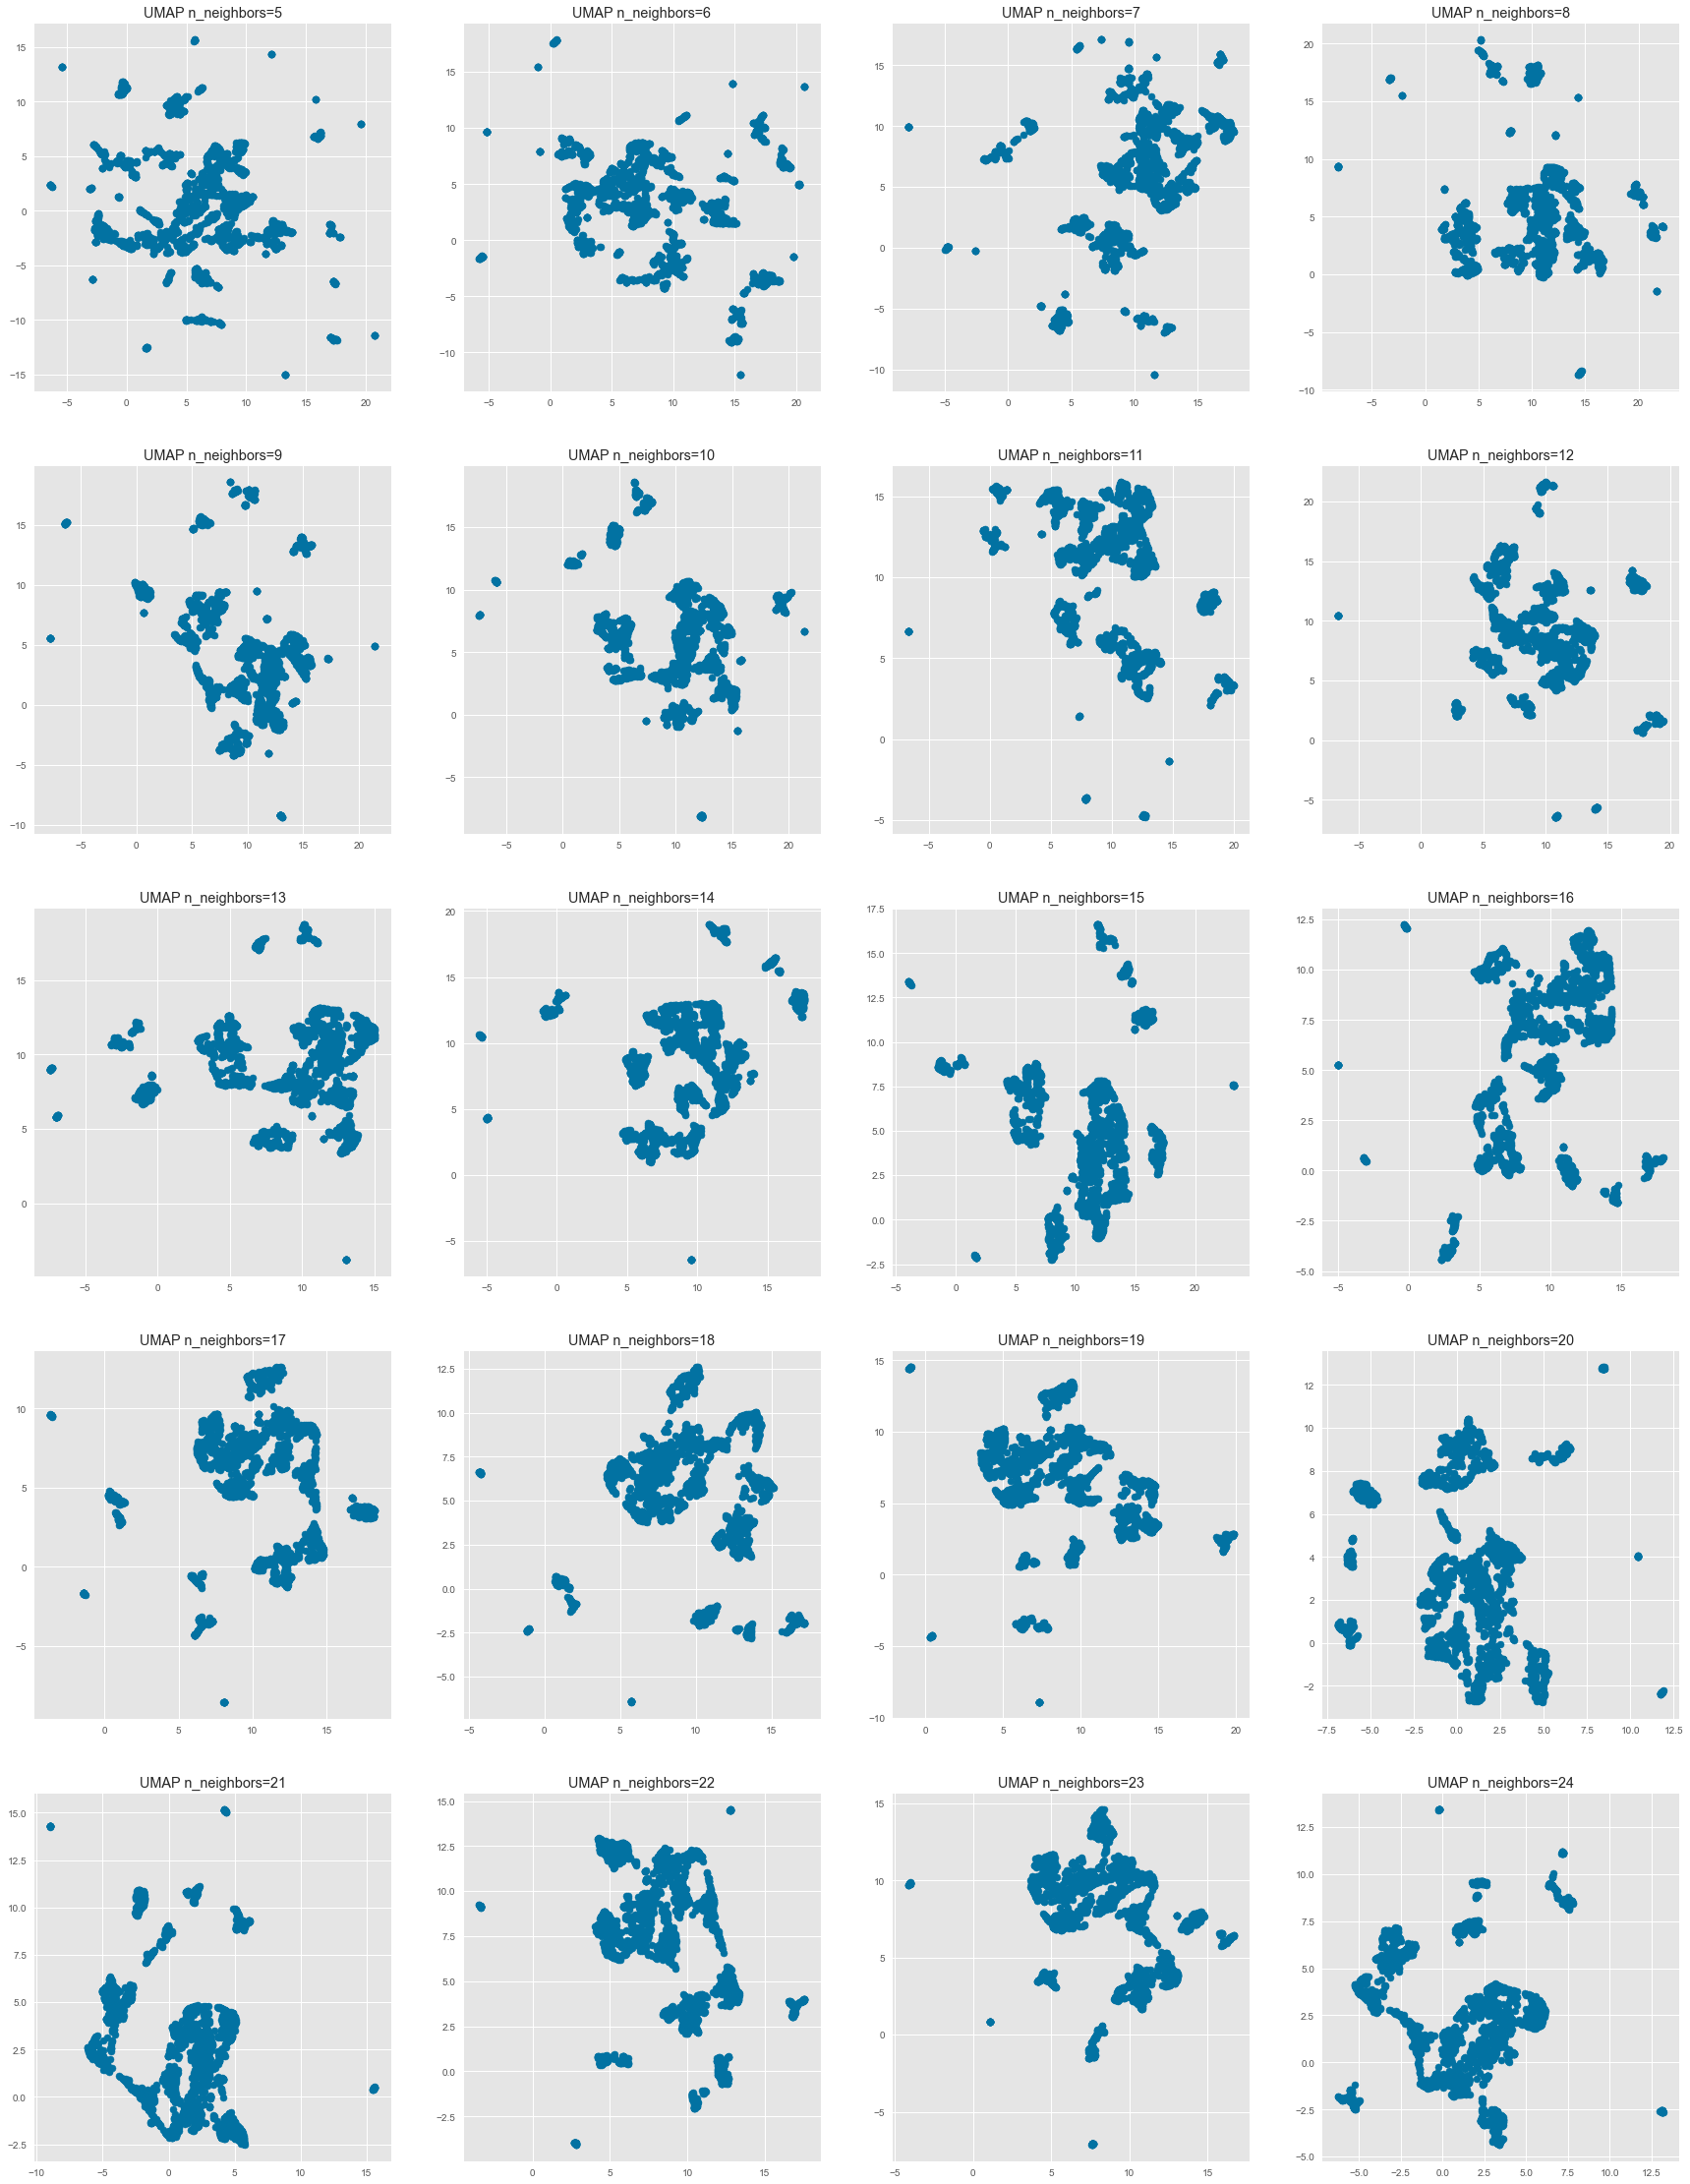

In [295]:
plt.figure(figsize=(30,40))
for i in range(5, 25):
    umap = UMAP(n_components=2, n_neighbors=i)
    x_umap = umap.fit_transform(X)
    plt.subplot(5, 4, i - 4, title=f'UMAP n_neighbors={i}')
    plt.scatter(x_umap[:, 0], x_umap[:, 1], c='b')

### Применяем алгоритм KMeans для метода UMAP

In [301]:
# Попробуем взять n_neigbors=22, довольно четко видна структура
umap = UMAP(n_components=2, n_neighbors=22)
x_umap = umap.fit_transform(X)
# Оценим silhouette_score для разного числа кластеров
for i in range(2, 30):
    kmeans = KMeans(n_clusters=i)
    kmeans_y = kmeans.fit_predict(x_umap)
    print(f'количество кластеров {i},', 'silhouette_score =', silhouette_score(x_umap, kmeans_y))

количество кластеров 2, silhouette_score = 0.39361104
количество кластеров 3, silhouette_score = 0.4867348
количество кластеров 4, silhouette_score = 0.46063393
количество кластеров 5, silhouette_score = 0.5076796
количество кластеров 6, silhouette_score = 0.5292845
количество кластеров 7, silhouette_score = 0.51459205
количество кластеров 8, silhouette_score = 0.515806
количество кластеров 9, silhouette_score = 0.5394347
количество кластеров 10, silhouette_score = 0.5383303
количество кластеров 11, silhouette_score = 0.5452523
количество кластеров 12, silhouette_score = 0.5525169
количество кластеров 13, silhouette_score = 0.5647086
количество кластеров 14, silhouette_score = 0.58312386
количество кластеров 15, silhouette_score = 0.6046371
количество кластеров 16, silhouette_score = 0.61203486
количество кластеров 17, silhouette_score = 0.60873365
количество кластеров 18, silhouette_score = 0.60902345
количество кластеров 19, silhouette_score = 0.5892572
количество кластеров 20, silho

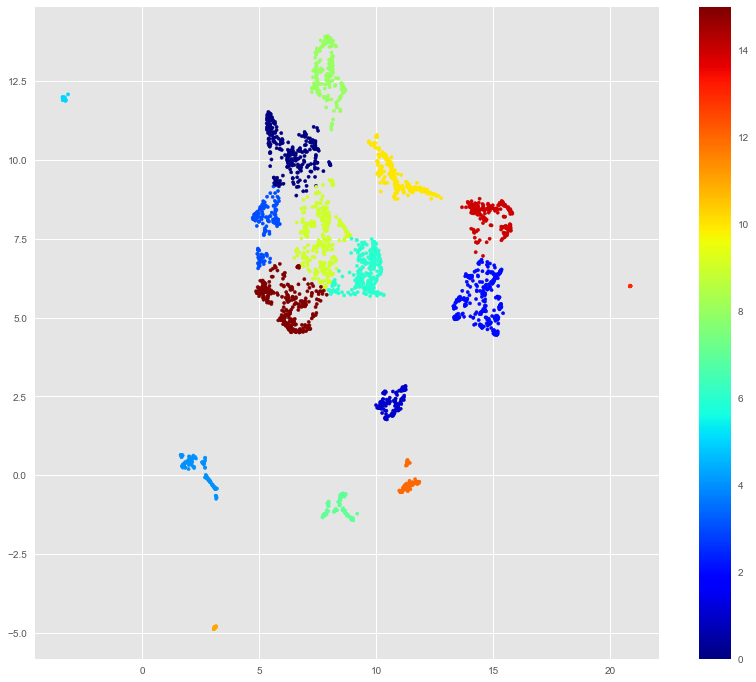

In [311]:
# Применим алгоритм KMeans с числом кластеров 16 - для него наибольший silhouette_score
kmeans_umap = KMeans(n_clusters=16)
kmeans_umap_y = kmeans_umap.fit_predict(x_umap)
# Визуализируем
plt.figure(figsize=(14,12))
plt.scatter(x_umap[:,0], x_umap[:, 1], c=kmeans_umap_y, cmap='jet', s=10)
plt.colorbar();

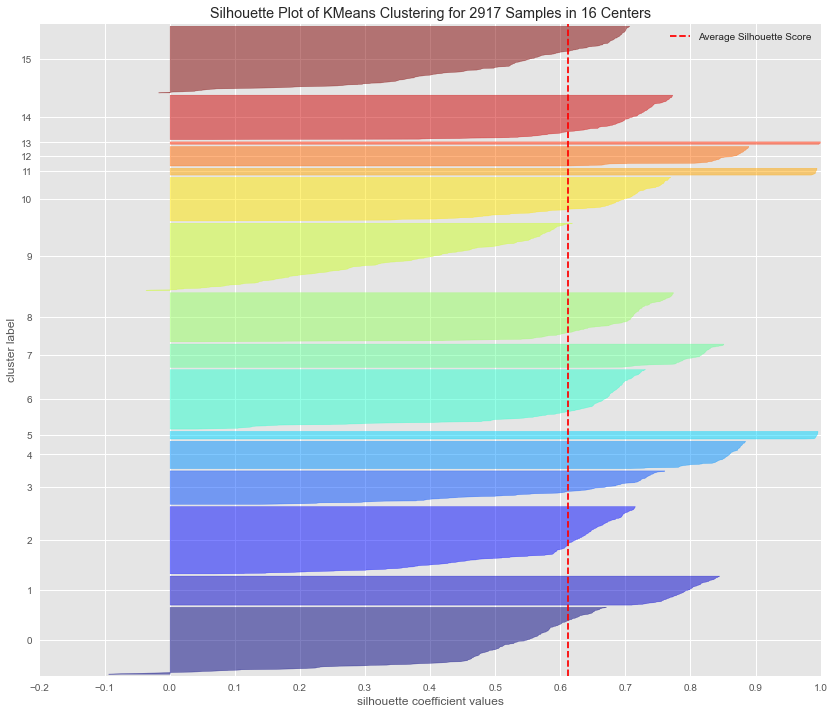

In [315]:
# Визуализируем silhouette_score с помощью yellowbrick
plt.figure(figsize=(14,12))
silhouette_visualizer(kmeans_umap, x_umap, colors='jet');